### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 15th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3.5 to 6.5. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to $\mu+\sigma_\mathrm{mean}$ and $\mu-\sigma_\mathrm{mean}$. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.5 to 5.5. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6.1\pm0.25$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6.1$ with standard deviation of $0.25$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

### <font color='green'>**PART ONE!**</font>

In [79]:
import numpy as np

data = np.load("hw4_data_1.npy") # Loading the dataset

voltage_measurements = data[:, 0]  # First column is measurements
voltage_uncertainties = data[:, 1]  # Second column is uncertainties

To compute the heteroscedastic sample mean, we do:

$$\hat{\mu} = \frac{\sum_i^N(\frac{x_i}{\sigma_i^2})}{\sum_i^N(\frac{1}{\sigma_i^2})}$$

As for the heteroscedastic standard error, we do:

$$\sigma_{\hat{\mu}}=\left[\sum_i^N\left(\frac{1}{\sigma_i^2}\right)\right]^{-\frac{1}{2}}$$

In [80]:
weights = 1 / (voltage_uncertainties ** 2) # Weights to apply to these things

hetero_mean = np.sum(weights * voltage_measurements) / np.sum(weights) # Weighted heteroscedastic mean

print("The heteroscedastic weighted mean is:", hetero_mean) # Print statement!

The heteroscedastic weighted mean is: 4.942118214425304


In [81]:
hetero_standard_error = (np.sum(weights)) ** (-1/2) # Heteroscedastic standard error

print("The heteroscedastic standard error is:", hetero_standard_error) # Print statement!

The heteroscedastic standard error is: 0.43024334605205083


### <font color='green'>**PART TWO!**</font>

We can compute the log likehihood using a similar function as to what was used in homework 3:

In [82]:
# Nice things to import
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
import matplotlib.pyplot as plt

In [83]:
# What's the data length lok like? Let's give this a shot!
x = np.linspace(0, 5, 100)

# Defining the standard squared-loss function.
def log_likelihood(mu, x, dx):
    return np.sum(((x - mu) / (2 * dx)) ** 2 - (1 / np.sqrt(2 * np.pi * dx))) 
    # Note the constant/main term comes from applying ln to the product

# Defining a lambda function that defines the sum of squared errors. 
f_squared = lambda beta: log_likelihood(beta[0], x=voltage_measurements, dx=voltage_uncertainties)

# Computing the maximum likelihood 
beta0 = (4) # My guess (for the moment)
beta_squared = optimize.fmin(f_squared, beta0)

# Final answer:
print("The MLE for the Gaussian distribution is:", beta_squared)

Optimization terminated successfully.
         Current function value: -1.896258
         Iterations: 15
         Function evaluations: 30
The MLE for the Gaussian distribution is: [4.94208984]


SRT: You got the right answer, but your Gaussian likelihood normalization is incorrect. Missing a log, the `dx` should be squared, and the sign should be the same as the chi squared portion of the function. -2 points

### <font color='green'>**PART THREE!**</font>

To calculate a non-log likelihood posterior probability density for the mean voltage, assuming a uniform prior for the mean in the range 3.5 to 6.5 (with nor,malization), we redefine the likelihood funciton for each individual likelihood, and take the integral (approximated using np.trapz) under each to get the pdf we're looking for.

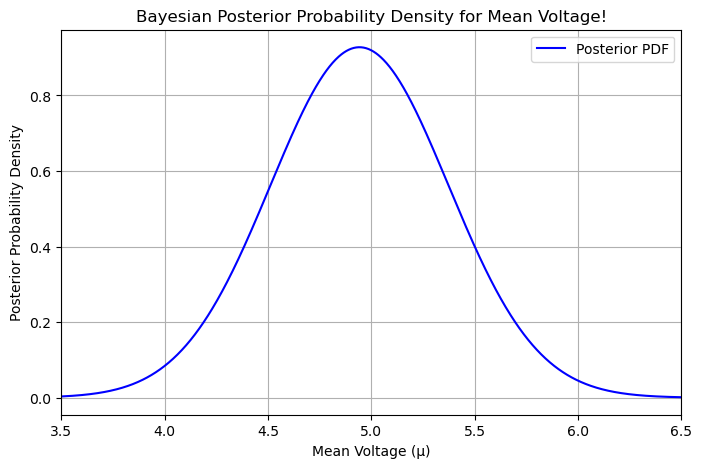

In [84]:
# Defining the range for the mean voltage (prior range)
mu_values_pt3 = np.linspace(3.5, 6.5, 1000) 

# Computing EACH individual likelihood
def individual_likelihood(mu, x, sigma):
    likelihood_value = np.exp(-0.5 * np.sum(((x - mu) / sigma) ** 2))
    return likelihood_value

# Computing the likelihood for each mu
likelihood_values_pt3 = np.array([individual_likelihood(mu, voltage_measurements, voltage_uncertainties) for mu in mu_values_pt3])

# Normalizing to get posterior PDF
posterior_pdf_pt3 = likelihood_values_pt3 / np.trapz(likelihood_values_pt3, mu_values_pt3) # Estimating the integral using np.trapz!

# Plotting the posterior distribution
plt.figure(figsize=(8, 5))
plt.plot(mu_values_pt3, posterior_pdf_pt3, label="Posterior PDF", color='b')
plt.xlabel("Mean Voltage (μ)")
plt.ylabel("Posterior Probability Density")
plt.xlim(3.5, 6.5)
plt.title("Bayesian Posterior Probability Density for Mean Voltage!")
plt.legend()
plt.grid()
plt.show()


### <font color='green'>**PART FOUR!**</font>

The cdf for this can actually come from ther function np.cumsum (thank you Don Terndrup!), which calcualtes the cumulative sum of everything before a point on an array, which sounds an awful lot like what we want with the cdf! Note it is wise to divide by the sum of the posterior pdf in total since we want the percentage of it covered by a certain point.

A credible region of $68.3\%$ leaves a region of $31.7\%$ behind, further split into two chunks of $15.85\%$. The lower bound of our credible region will fall there, while the upper bound will be at $100\%-15.85\%=84.15\%$.

Then, finally, the map estimate will just be where the $\mu$ value in the posterior distribution is highest.

With that all squared away, let's do it!!

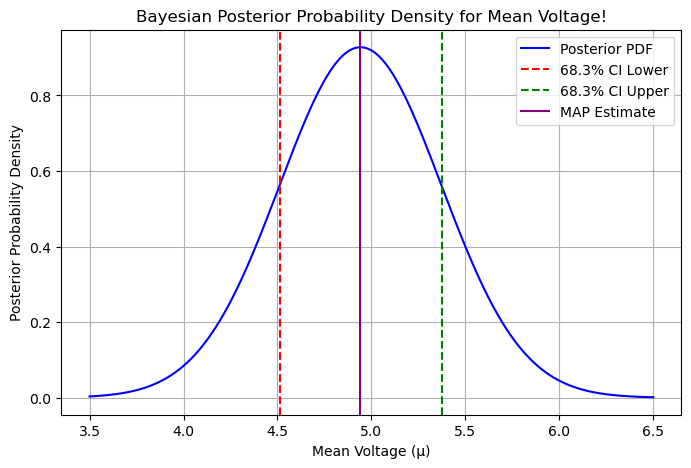

Equal-tailed 68.3% credible interval: (4.512012012012012, 5.373873873873874)
MAP estimate of the mean: 4.941441441441441


In [85]:
# Computing the CDF (cumulative sum of posterior PDF divided by total sum of posterior PDF)
cdf = np.cumsum(posterior_pdf_pt3) / np.sum(posterior_pdf_pt3)

# The bounds of the 68.3% credible region (searchsorted finds the index of the first value that is greater than the given value)
lower_bound = mu_values_pt3[np.searchsorted(cdf, 0.1585)]
upper_bound = mu_values_pt3[np.searchsorted(cdf, 0.8415)]

# Finding Maximum A Posteriori (MAP) estimate using np.argmax
map_estimate = mu_values_pt3[np.argmax(posterior_pdf_pt3)]

# Plotting the posterior distribution AND the 68.3% credible interval
plt.figure(figsize=(8, 5))
plt.plot(mu_values_pt3, posterior_pdf_pt3, label="Posterior PDF", color='b')
plt.axvline(lower_bound, color='r', linestyle='--', label="68.3% CI Lower")
plt.axvline(upper_bound, color='g', linestyle='--', label="68.3% CI Upper")
plt.axvline(map_estimate, color='purple', linestyle='-', label="MAP Estimate")
plt.xlabel("Mean Voltage (μ)")
plt.ylabel("Posterior Probability Density")
plt.title("Bayesian Posterior Probability Density for Mean Voltage!")
plt.legend()
plt.grid()
plt.show()

# Printing the results for your viewing pleasure
print(f"Equal-tailed 68.3% credible interval: ({lower_bound}, {upper_bound})")
print(f"MAP estimate of the mean: {map_estimate}")


### <font color='green'>**PART FIVE!**</font>

To do this, we just repeat the process for the updated prior ($4.5\leq\mu\leq 5.5$) as so:

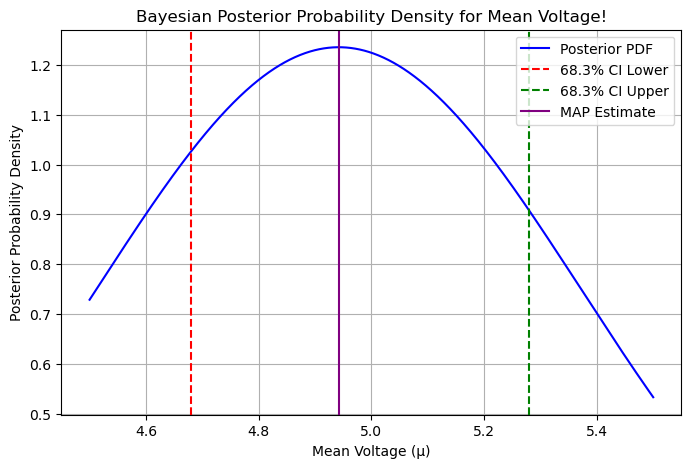

Equal-tailed 68.3% credible interval: (4.6791791791791795, 5.27977977977978)
MAP estimate of the mean: 4.9424424424424425


In [86]:
# Defining the range for the mean voltage (prior range)
mu_values_pt5 = np.linspace(4.5, 5.5, 1000) 

# Computing the likelihood for each mu
likelihood_values = np.array([individual_likelihood(mu, voltage_measurements, voltage_uncertainties) for mu in mu_values_pt5])

# Normalizing to get posterior PDF
posterior_pdf_pt5 = likelihood_values / np.trapz(likelihood_values, mu_values_pt5)

# Computing the CDF (cumulative sum of posterior PDF divided by total sum of posterior PDF)
cdf = np.cumsum(posterior_pdf_pt5) / np.sum(posterior_pdf_pt5)

# The bounds of the 68.3% credible region (searchsorted finds the index of the first value that is greater than the given value)
lower_bound = mu_values_pt5[np.searchsorted(cdf, 0.1585)]
upper_bound = mu_values_pt5[np.searchsorted(cdf, 0.8415)]

# Finding Maximum A Posteriori (MAP) estimate using np.argmax
map_estimate = mu_values_pt5[np.argmax(posterior_pdf_pt5)]

# Plotting the posterior distribution AND the 68.3% credible interval
plt.figure(figsize=(8, 5))
plt.plot(mu_values_pt5, posterior_pdf_pt5, label="Posterior PDF", color='b')
plt.axvline(lower_bound, color='r', linestyle='--', label="68.3% CI Lower")
plt.axvline(upper_bound, color='g', linestyle='--', label="68.3% CI Upper")
plt.axvline(map_estimate, color='purple', linestyle='-', label="MAP Estimate")
plt.xlabel("Mean Voltage (μ)")
plt.ylabel("Posterior Probability Density")
plt.title("Bayesian Posterior Probability Density for Mean Voltage!")
plt.legend()
plt.grid()
plt.show()

# Printing the results for your viewing pleasure
print(f"Equal-tailed 68.3% credible interval: ({lower_bound}, {upper_bound})")
print(f"MAP estimate of the mean: {map_estimate}")

### <font color='green'>**PART SIX!**</font>

To account for the old experiment where the mean was actually $6.1\pm0.25$, we can construct a Gaussian prior centered around the new value, and multiply it with the posterior and proceed with our analysis as so: 

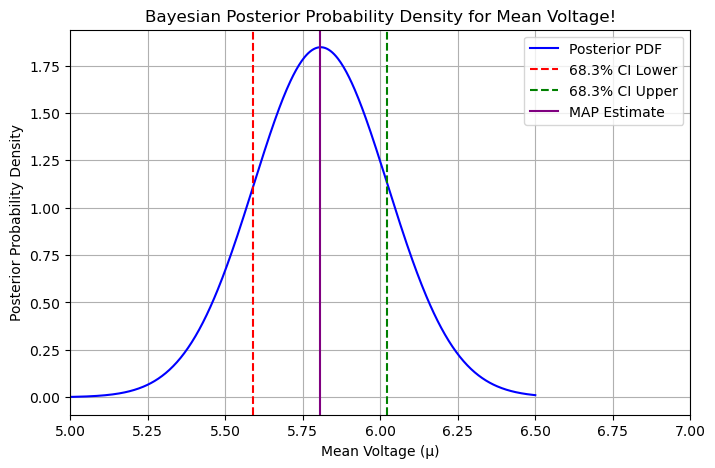

Equal-tailed 68.3% credible interval: (5.59009009009009, 6.0225225225225225)
MAP estimate of the mean: 5.806306306306306


In [87]:
# Defining the range for the mean voltage (prior range)
mu_values_pt6 = np.linspace(3.5, 6.5, 1000) 

# Computing the likelihood for each mu
likelihood_values = np.array([individual_likelihood(mu, voltage_measurements, voltage_uncertainties) for mu in mu_values_pt6])

# Computing the prior distribition (Gaussian)
prior_pdf = norm.pdf(mu_values_pt6, loc=6.1, scale=0.25)

# Normalizing and multiplying by prior to get posterior PDF
posterior_pdf_pt6 = likelihood_values * prior_pdf / np.trapz((likelihood_values * prior_pdf), mu_values_pt6)

# Computing the CDF (cumulative sum of posterior PDF divided by total sum of posterior PDF)
cdf = np.cumsum(posterior_pdf_pt6) / np.sum(posterior_pdf_pt6)

# The bounds of the 68.3% credible region (searchsorted finds the index of the first value that is greater than the given value)
lower_bound = mu_values_pt6[np.searchsorted(cdf, 0.1585)]
upper_bound = mu_values_pt6[np.searchsorted(cdf, 0.8415)]

# Finding Maximum A Posteriori (MAP) estimate using np.argmax
map_estimate = mu_values_pt6[np.argmax(posterior_pdf_pt6)]

# Plotting the posterior distribution AND the 68.3% credible interval
plt.figure(figsize=(8, 5))
plt.plot(mu_values_pt6, posterior_pdf_pt6, label="Posterior PDF", color='b')
plt.axvline(lower_bound, color='r', linestyle='--', label="68.3% CI Lower")
plt.axvline(upper_bound, color='g', linestyle='--', label="68.3% CI Upper")
plt.axvline(map_estimate, color='purple', linestyle='-', label="MAP Estimate")
plt.xlim(5.0, 7.0)
plt.xlabel("Mean Voltage (μ)")
plt.ylabel("Posterior Probability Density")
plt.title("Bayesian Posterior Probability Density for Mean Voltage!")
plt.legend()
plt.grid()
plt.show()

# Printing the results for your viewing pleasure
print(f"Equal-tailed 68.3% credible interval: ({lower_bound}, {upper_bound})")
print(f"MAP estimate of the mean: {map_estimate}")

### <font color='green'>**PART SEVEN!**</font>

Now, we are going to plot all of these distributions on the SAME graph with an xlim ranging from 0 to 10:

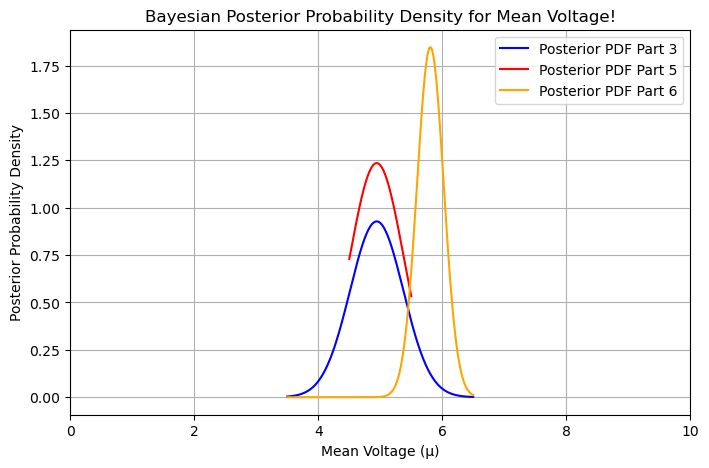

In [89]:
# Plotting all three posterior distributions!
plt.figure(figsize=(8, 5))
plt.plot(mu_values_pt3, posterior_pdf_pt3, label="Posterior PDF Part 3", color='blue')
plt.plot(mu_values_pt5, posterior_pdf_pt5, label="Posterior PDF Part 5", color='red')
plt.plot(mu_values_pt6, posterior_pdf_pt6, label="Posterior PDF Part 6", color='orange')
plt.xlim(0, 10)
plt.xlabel("Mean Voltage (μ)")
plt.ylabel("Posterior Probability Density")
plt.title("Bayesian Posterior Probability Density for Mean Voltage!")
plt.legend()
plt.grid()
plt.show()

SRT: The pdf for all three is defined at all parts of the x-axis, even when it goes to zero. So the curves should be plotted across the same range. -2 points.

### <font color='green'>**PART EIGHT!**</font>

Now, we are going to study how the normalization constants used relate to the Bayesian evidence for each particular model. First, we are going to compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value from part one. I'll then compare this to the evidence for the prior in part three, taking the ratio of what np.trapz spits out for each.

How do we find the evidence under the delta function distribution? The delta function means that we will only have a value of probability when the mean voltage hits the best fit voltage, meaning the evidence integral will only produce the likelihood at the best-fit mean:

$$P(\mu)=\delta(\mu-\mu_{bf})\to E_{vidence}=\int P(x|\mu)P(\mu)d\mu=\int P(x|\mu)\delta(\mu-\mu_{bf})d\mu=P(x|\mu_{bf})$$

To calculate this, we go as so:

In [90]:
# Computing Bayesian evidence for wide prior from part three 
E_wide = np.trapz(likelihood_values_pt3, mu_values_pt3)

# Computing Bayesian evidence for delta prior with likelihood at best-fit mean from Step 1
E_delta = individual_likelihood(hetero_mean, voltage_measurements, voltage_uncertainties)

# Computing the Bayes Factor!
bayes_factor = E_delta / E_wide
print(f"The Bayes Factor is: {bayes_factor}")

The Bayes Factor is: 0.9277565399313897


By just a hair, the wide model seems to fit the data better.

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in Lecture 9? 

### Solution

### <font color='green'>**PART ONE!**</font>

Loading the dataset here:

In [91]:
# Loading the dataset
data = np.load("hw4_data_2.npy") 

# Putting the data into variables
x = data[:, 0]
y = data[:, 1]  
sigma_y = data[:, 2]

### <font color='green'>**PART TWO!**</font>

Here, we use the given functions to construct our likelihood values, which we then multiply by the prior, and THEN divide by the traps to construct the prior pdf.

In [92]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

Now, we can conduct a fit on the data as so, constructing our theta prior in a function, making a grid of them, and then using a list comprension to construct an array that defines points at every value in our linspace:

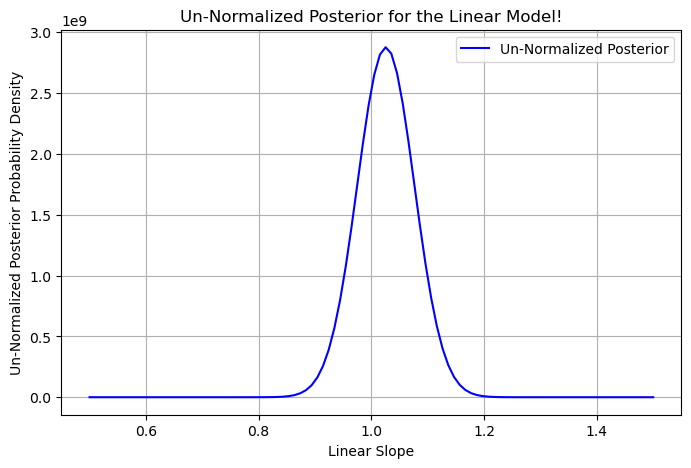

In [93]:
# Defining the prior (uniform in range [0.5, 1.5])
def prior_linear(theta1):
    if 0.5 <= theta1 <= 1.5:
        return 1.0
    else:
        return 0.0

# Defining grid of theta1 values between 0.5 and 1.5
theta1_values = np.linspace(0.5, 1.5, 100)

# Computing un-normalized posterior (likelihood * prior) (like for what Kyle said! Only need Bayes ratio!)
posterior_unnorm = np.array([np.exp(logL([-0.23, theta1], data)) * prior_linear(theta1) for theta1 in theta1_values])

# Plotting the un-normalized posterior
plt.figure(figsize=(8, 5))
plt.plot(theta1_values, posterior_unnorm, label="Un-Normalized Posterior", color='b')
plt.xlabel("Linear Slope")
plt.ylabel("Un-Normalized Posterior Probability Density")
plt.title("Un-Normalized Posterior for the Linear Model!")
plt.legend()
plt.grid()
plt.show()

### <font color='green'>**PART THREE!**</font>

$$E_{vidence}=\int P(x|\theta)P(\theta)d\mu$$

In prep to NOT compute the big nasty integral under the Bayes equation, we can simply just compute the edivence as we have done before, which is an integral over our entire posterior at every theta (slope) value. I will use np.trapz to demonstrate:

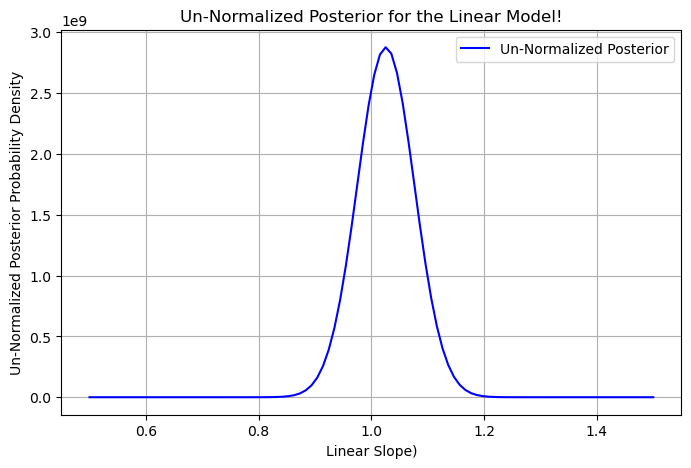

Bayesian Evidence: 365684733.16065943


In [94]:
# Computing Bayesian evidence by integrating over theta1
bayesian_evidence = np.trapz(posterior_unnorm, theta1_values)

# Plotting the un-normalized posterior
plt.figure(figsize=(8, 5))
plt.plot(theta1_values, posterior_unnorm, label="Un-Normalized Posterior", color='b')
plt.xlabel("Linear Slope)")
plt.ylabel("Un-Normalized Posterior Probability Density")
plt.title("Un-Normalized Posterior for the Linear Model!")
plt.legend()
plt.grid()
plt.show()

# Print statement!
print(f"Bayesian Evidence: {bayesian_evidence}")

HUUUUGE number!

SRT: Good!

### <font color='green'>**PART FOUR!**</font>

We now have to create the prior containing the coefficient for the new quadratic term, constructing an un-normalized posterior for the 2D model (making a matrix), and then plotting them together on a meshgrid graph (Help in graphing gathered from https://stackoverflow.com/questions/56221246/best-way-to-plot-a-2d-contour-plot-with-a-numpy-meshgrid):

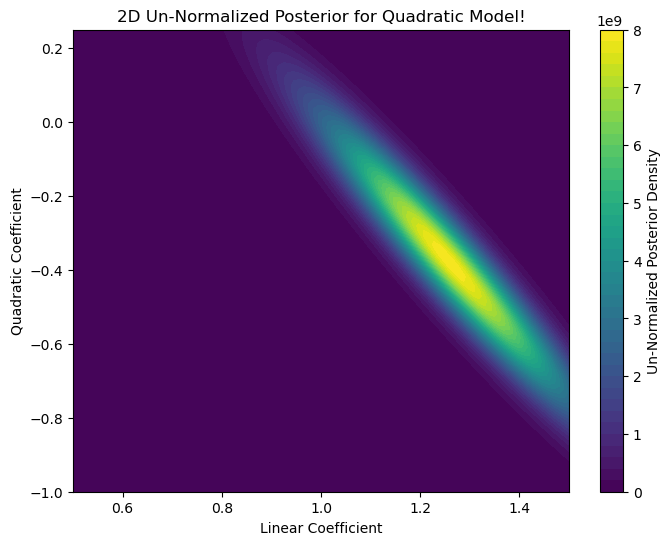

In [95]:
# Defining the quadratic prior here
def prior_quadratic(theta2):
    if -1.0 <= theta2 <= 0.25:
        return 1.0 
    else:
        return 0.0

# Defining grid for the quadratic coefficients
theta2_values = np.linspace(-1.0, 0.25, 100)

# Computing un-normalized posterior for 2D model (likelihood * prior) (defining matrix of zeroes, and then adding values)
posterior_unnorm_2D = np.zeros((len(theta1_values), len(theta2_values)))
for i, theta1 in enumerate(theta1_values):
    for j, theta2 in enumerate(theta2_values):
        posterior_unnorm_2D[i, j] = (np.exp(logL([-0.23, theta1, theta2], data)) * prior_linear(theta1) * prior_quadratic(theta2))

# Plotting the 2D posterior
theta1_mesh, theta2_mesh = np.meshgrid(theta1_values, theta2_values, indexing='ij') # Making the coordinate grid to build the plot from!
plt.figure(figsize=(8, 6))
plt.contourf(theta1_mesh, theta2_mesh, posterior_unnorm_2D, levels=50, cmap='viridis')
plt.colorbar(label="Un-Normalized Posterior Density")
plt.xlabel("Linear Coefficient")
plt.ylabel("Quadratic Coefficient")
plt.title("2D Un-Normalized Posterior for Quadratic Model!")
plt.show()

Sick as hell!!!

SRT: Lovely

### <font color='green'>**PART FIVE!**</font>

Now, we compute the Bayesian evidence for the quadratic model. Note that it is a double integral, so we stack two np.trapz methods within each other:

In [96]:
# Computing Bayesian evidence for quadratic model
bayesian_evidence_quadratic = np.trapz(np.trapz(posterior_unnorm_2D, theta2_values, axis=1), theta1_values)

### <font color='green'>**PART SIX!**</font>

To finish out, we calculate the Bayes factor and see which model is favored:

In [97]:
# Computing Bayes Factor (quadratic vs linear)
bayes_factor_linear_vs_quadratic = bayesian_evidence / bayesian_evidence_quadratic

# Printing results
print(f"Bayesian Evidence (Linear Model): {bayesian_evidence}")
print(f"Bayesian Evidence (Quadratic Model): {bayesian_evidence_quadratic}")
print(f"Bayes Factor (Linear vs Quadratic): {bayes_factor_linear_vs_quadratic}")

Bayesian Evidence (Linear Model): 365684733.16065943
Bayesian Evidence (Quadratic Model): 613042113.2712488
Bayes Factor (Linear vs Quadratic): 0.5965083397114959


Since the Bayes factor is lower than 1, the quadratic model is favored, suggesting the added complexity is justified.

SRT: Correct procedure! Your numerical answer for the quadratic model is different from mine, perhaps through the double `trapz` rather than direct double integral. -1 point

SRT: 45/50